# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Признаки**

DateCrawled — дата скачивания анкеты из базы
<br>VehicleType — тип автомобильного кузова
<br>RegistrationYear — год регистрации автомобиля
<br>Gearbox — тип коробки передач
<br>Power — мощность (л. с.)
<br>Model — модель автомобиля
<br>Kilometer — пробег (км)
<br>RegistrationMonth — месяц регистрации автомобиля
<br>FuelType — тип топлива
<br>Brand — марка автомобиля
<br>Repaired — была машина в ремонте или нет
<br>DateCreated — дата создания анкеты
<br>NumberOfPictures — количество фотографий автомобиля
<br>PostalCode — почтовый индекс владельца анкеты (пользователя)
<br>LastSeen — дата последней активности пользователя

**Целевой признак**
<br>Price — цена (евро)

## Подготовка данных

### Знакомство с данными

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

from lightgbm import LGBMRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
import lightgbm as lgb

from catboost import CatBoostRegressor, Pool

STATE = 12345

In [2]:
data = pd.read_csv('/datasets/autos.csv')

In [3]:
def data_info(df):
        display(df.head(5))
        print("Пропусков в данных: ")
        print(df.isna().sum().sum(), end='\n'*2)
        print("Дубликатов в данных: ", df.duplicated().sum())
        print()
        df.info()
        display(df.describe())
        def data_isna(df):
            isna = pd.DataFrame(round(df.isna().mean()*100,)).style.background_gradient('coolwarm')
            return isna
        display(data_isna(df))

In [4]:
data_info(data)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Пропусков в данных: 
181077

Дубликатов в данных:  4

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen      

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


,0
DateCrawled,0.000000
Price,0.000000
VehicleType,11.000000
RegistrationYear,0.000000
Gearbox,6.000000
Power,0.000000
Model,6.000000
Kilometer,0.000000
RegistrationMonth,0.000000
FuelType,9.000000


**Изучите данные. Заполните пропущенные значения и обработайте аномалии в столбцах. Если среди признаков имеются неинформативные, удалите их.**

- У нас 354 - тысячи строк с даными
- в которых 181 тыс. пропусков 
- и 4 дубликата(дубликаты удалим сразу, так как на общем обьеме они данных они не повлияют)
- тип данных столбцов: "DateCrawled, DateCreated, LastSeen" с датами - object, но так как даты скачивания и создания анкеты, появления пользователя в сети не влияют на цену авто - не информативные признаки, данные столбцы будут удалены и обрабатывать их нет смысла. Остальные типы данных соответствуют
- так же удалю столбцы "NumberOfPictures, PostalCode, RegistrationMonth" - тоже не информативные признаки

### Подготовка данных

Сразу удалим наши 4 дубликата

In [5]:
data = data.drop_duplicates()
data.duplicated().sum()

0

#### Работа с аномалиями

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365.0,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,5.714650,0.0,50508.503800
std,4514.176349,90.228466,189.851330,37905.083858,3.726432,0.0,25783.100078
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


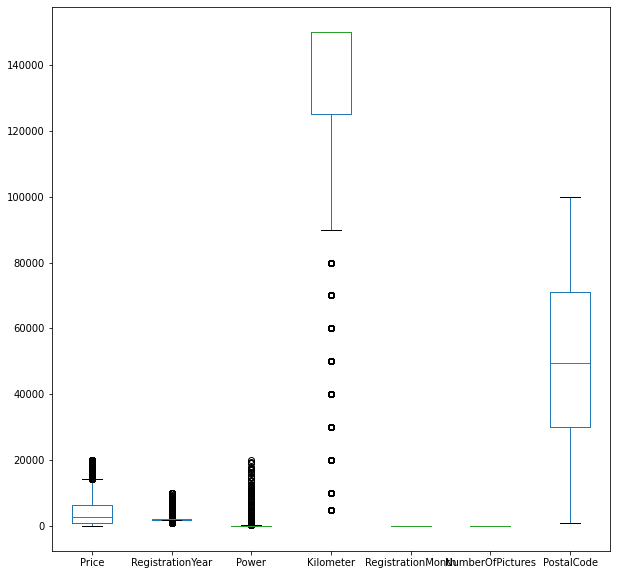

In [6]:
data.plot(kind='box', figsize=(10,10),)
data.describe()

Проверю зависимость цены от других признаков

In [7]:
data.corr()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
Price,1.000000,0.026916,0.158872,-0.333207,0.110580,NaN,0.076058
RegistrationYear,0.026916,1.000000,-0.000828,-0.053448,-0.011619,NaN,-0.003459
Power,0.158872,-0.000828,1.000000,0.024006,0.043379,NaN,0.021662
Kilometer,-0.333207,-0.053448,0.024006,1.000000,0.009575,NaN,-0.007685
RegistrationMonth,0.110580,-0.011619,0.043379,0.009575,1.000000,NaN,0.013996
NumberOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostalCode,0.076058,-0.003459,0.021662,-0.007685,0.013996,NaN,1.000000


Из данных можно выделить следующие аномалии:
- Столбец "NumberOfPictures" полностью без даннах, в дальнейшем удалим вместе с другими неинформативными столбцами
- Год регистрации(RegistrationYear) -  минимальный в обьявлении 1000, а максимальный 9999, попробуем ограничить данные последними 100 годами(мб антиквариат в обьявлениях)
- Мощность л.с.(Power) - минимальный показатель 0л.с. - разберем его детальнее, максимум 20 000л.с. - это уже либо ошибка, либо обьявление не для обычного пользователя(самый мощный авто в мире на 2022 год - электрический гиперкар Owl от японской компании Aspark 2012л.с.)
- Цена продажи (Price) - имеет максимальное значение в 20 000 евро, при среднем показателе и стандартоном отклонении ~4500, тоже может быть аномалией и сильно исказить работу моделей
- Километраж авто не вызывает подозрений, так как вполне возможны обьявления с маленьким пробегом авто

Начнем с ограничения по годам

In [8]:
#DateCreated — дата создания анкеты, год регистрации не может быть выше даты регистрации(в машины из будующего мы не верим)
data['DateCreated'] = pd.to_datetime(data['DateCreated'], yearfirst=True)

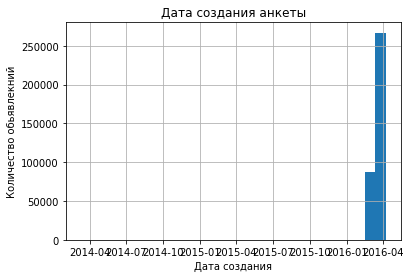

/tmp/ipykernel_289/1982608716.py:7: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  data['DateCreated'].describe()


count                  354365
unique                    109
top       2016-04-03 00:00:00
freq                    13718
first     2014-03-10 00:00:00
last      2016-04-07 00:00:00
Name: DateCreated, dtype: object

In [9]:
plt.hist(data['DateCreated'], bins=30)
plt.title('Дата создания анкеты')
plt.xlabel('Дата создания')
plt.ylabel('Количество обьявлекний')
plt.grid(True)
plt.show()
data['DateCreated'].describe()

Начнем с ограничения по годам

Максимальная дата обьявления апрель 2016, регистрация старше этой даты стоит удалить, для этого просмотрим столбцы "RegistrationYear" и "RegistrationMonth"

Но в столбце "RegistrationMonth" присутствуют месяца `0`, которых не существуют, заменим их на первый день месяца

In [10]:
data.loc[data['RegistrationMonth'] == 0, 'RegistrationMonth'] = 1

In [11]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365.0,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,5.820056,0.0,50508.503800
std,4514.176349,90.228466,189.851330,37905.083858,3.574336,0.0,25783.100078
min,0.000000,1000.000000,0.000000,5000.000000,1.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [12]:
data.shape

(354365, 16)

In [13]:
data = data[(data['RegistrationYear'] > 1916)]
data =  data[(data['RegistrationMonth'] < 4) | (data['RegistrationYear'] < 2016)]

In [14]:
data.shape

(340637, 16)

минус 1500 строк
<br>Далее Мощность - ограничим суперкаром в 2012л.с

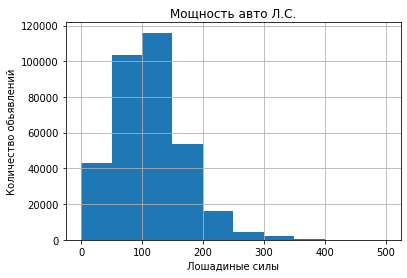

count    340637.000000
mean        110.798847
std         186.393834
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

In [15]:
plt.hist(data['Power'], bins=10,  range=(0,500))
plt.title('Мощность авто Л.С.')
plt.xlabel('Лошадиные силы')
plt.ylabel('Количество обьявлений')
plt.grid(True)
plt.show()
data['Power'].describe()

Минимальная мощность продаваемых авто в районе 50л.с, ограничим данные, что бы убрать обьявления с авто без мощности двигателя

In [16]:
data = data[(data['Power'] < 2012) & (data['Power'] > 50)]

In [17]:
data['Power'].describe()

count    293314.000000
mean        124.113367
std          63.728336
min          51.000000
25%          82.000000
50%         115.000000
75%         150.000000
max        2009.000000
Name: Power, dtype: float64

In [18]:
data.shape

(293314, 16)

удалив авто по минимальной и максимальной мощности мы удалили 60 000, если в дальнейшем показатели модели будут не удолетворительными, можно вернуться к пересмотру данной метрики
<br>Теперь займусь аномалией в столбце цен, с помощью формул поиска квартилей, удалю анамалии, которые не входят в диапозон нормы

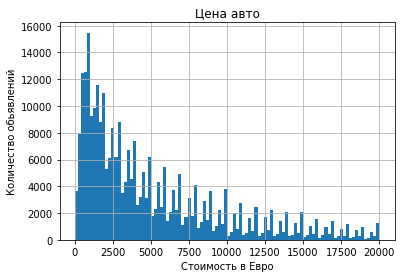

count    293314.0000
mean       4863.7055
std        4633.9141
min           0.0000
25%        1321.0000
50%        3200.0000
75%        6999.0000
max       20000.0000
Name: Price, dtype: float64

In [19]:
plt.hist(data['Price'], bins=100,  range=(20,20000))
plt.title('Цена авто')
plt.xlabel('Стоимость в Евро')
plt.ylabel('Количество обьявлений')
plt.grid(True)
plt.show()
data['Price'].describe()

Пик цену приходится на 500-1000 евро, ограничим минимальный порог цены в 500, что бы оставить малобюджетные авто и отсечь совсем дешовые

In [20]:
data.shape

(293314, 16)

In [21]:
data = data[(data['Price'] > 500)]

In [22]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,268723.000000,268723.000000,268723.000000,268723.000000,268723.000000,268723.0,268723.000000
mean,5285.636280,2003.566379,126.408339,127672.342896,6.057851,0.0,51572.340697
std,4616.429953,27.483488,62.654161,36909.827645,3.486424,0.0,25722.877739
min,501.000000,1937.000000,51.000000,5000.000000,1.000000,0.0,1067.000000
25%,1700.000000,2000.000000,87.000000,125000.000000,3.000000,0.0,31191.000000
50%,3650.000000,2004.000000,116.000000,150000.000000,6.000000,0.0,50769.000000
75%,7500.000000,2008.000000,150.000000,150000.000000,9.000000,0.0,72336.000000
max,20000.000000,9999.000000,2009.000000,150000.000000,12.000000,0.0,99998.000000


In [23]:
data.shape

(268723, 16)

После обработки анамалий было удалено 85000 строк

#### Удаление пропусков

Теперь займусь пропусками
<br>Ещё раз проверю количество пропусков, в процентном соотношении

In [24]:
pd.DataFrame(round(data.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
DateCrawled,0.000000
Price,0.000000
VehicleType,3.000000
RegistrationYear,0.000000
Gearbox,2.000000
Power,0.000000
Model,3.000000
Kilometer,0.000000
RegistrationMonth,0.000000
FuelType,4.000000


Очень много пропусков, если удалить данные, то будет большая потеря и возможность плохое обучения моделей, заменим пропуски на наиболее часто встречающимся значением, так как пропуски в "Категориальных признаках"  и это не должно так повредить обучению модели как удаление этих данных.
<br> в столбце "Repaired — была машина в ремонте или нет", замену произведу на "no"

In [25]:
data.shape

(268723, 16)

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 268723 entries, 1 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        268723 non-null  object        
 1   Price              268723 non-null  int64         
 2   VehicleType        260203 non-null  object        
 3   RegistrationYear   268723 non-null  int64         
 4   Gearbox            264570 non-null  object        
 5   Power              268723 non-null  int64         
 6   Model              259636 non-null  object        
 7   Kilometer          268723 non-null  int64         
 8   RegistrationMonth  268723 non-null  int64         
 9   FuelType           256877 non-null  object        
 10  Brand              268723 non-null  object        
 11  Repaired           233768 non-null  object        
 12  DateCreated        268723 non-null  datetime64[ns]
 13  NumberOfPictures   268723 non-null  int64   

In [27]:
column = ['VehicleType', 'Gearbox', 'Model', 'FuelType']
for col in column:
    data[col] = data[col].fillna('unknown')

data['Repaired'] = data['Repaired'].fillna('no')

In [28]:
pd.DataFrame(round(data.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
DateCrawled,0.000000
Price,0.000000
VehicleType,0.000000
RegistrationYear,0.000000
Gearbox,0.000000
Power,0.000000
Model,0.000000
Kilometer,0.000000
RegistrationMonth,0.000000
FuelType,0.000000


#### Не информативные столбцы

Последними действиями под "нож" отправляю не информативные столбцы

In [29]:
data.shape

(268723, 16)

In [30]:
data = data.drop(columns=['DateCrawled', 'DateCreated', 'LastSeen', 'NumberOfPictures', 'PostalCode', 'RegistrationMonth'], axis=1)

In [31]:
data.shape

(268723, 10)

#### Вывод

**В ходе моих действий я удалил 19364 строк, убирая аномалии для адекватного обучения модели.
<br> Все пропуски оказались в категориальных признаках и были заменены на наиболее повторяющиеся варианты, это было сделано в замен удаления пропусков, так как иначе была бы потеря более 50% данных
<br> Все не информативные столбцы были так же удалены, для облегчения обучения модели
<br> Дубликатов в данных оказалось ничтожно мало и они так же были удалены**

## Обучение моделей

In [118]:
#переменные составления итоговой таблицы
best_score_tabl = []
best_time_fit = []
best_time_pred = []

### Разделение на выборки

In [33]:
data.shape

(268723, 10)

In [34]:
features = data.drop(['Price'] , axis=1)
target = data['Price']

features_train, features_valid, target_train, target_valid = train_test_split(features,
                                                                              target, 
                                                                              test_size=0.5, 
                                                                              random_state=STATE)
# Выделил обучающую и валидационную выборки

In [35]:
display(features.shape, target.shape)

(268723, 9)

(268723,)

In [36]:
display('Features:',features_train.shape[0]+features_valid.shape[0]==features.shape[0],
        'Target:',target_train.shape[0]+target_valid.shape[0]==target.shape[0])

'Features:'

True

'Target:'

True

### Случайный лес

#### Кодирование категориальных признаков

In [37]:
#копируем выборки, что бы не изменять основные данные для других моделей
features_train_ord = features_train.copy()
features_valid_ord = features_valid.copy()

In [38]:
columns=['VehicleType', 'Gearbox','Model', 'FuelType','Brand', 'Repaired']

In [39]:
ord_enc = OrdinalEncoder(handle_unknown='ignore')
ord_enc.fit(features_train[columns])

OrdinalEncoder(handle_unknown='ignore')

In [40]:
def OrdinalCod(df,column):
    df[column] = ord_enc.transform(df[column])
    return df

In [41]:
features_train_ord = OrdinalCod(features_train_ord,columns)
features_valid_ord = OrdinalCod(features_valid_ord,columns)

In [42]:
features_train_ord

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
333553,4.0,2005,1.0,163,11.0,150000,2.0,2.0,0.0
220304,8.0,1995,1.0,90,168.0,150000,6.0,38.0,0.0
219591,4.0,2008,1.0,95,32.0,125000,6.0,20.0,0.0
35651,8.0,2007,1.0,140,27.0,150000,2.0,1.0,0.0
7530,7.0,2016,1.0,90,82.0,150000,7.0,24.0,0.0
...,...,...,...,...,...,...,...,...,...
209697,4.0,2005,0.0,140,115.0,125000,2.0,38.0,0.0
63355,4.0,2001,1.0,98,10.0,150000,6.0,19.0,0.0
114087,4.0,1993,1.0,90,19.0,150000,6.0,1.0,0.0
101982,5.0,2009,1.0,65,149.0,125000,6.0,23.0,1.0


#### Обучение модели

In [43]:
%%time
param_grid = {'max_depth': range(2, 11, 2),
              'n_estimators': range(10, 100, 10)
              }             

model = RandomForestRegressor(random_state=STATE)
search = GridSearchCV(model, param_grid, cv=3, scoring='neg_root_mean_squared_error')
search.fit(features_train_ord, target_train)
print('Лучшее значение RMSE для случайного леса: {}'
      '\n при значениях гиперпараметров: {}'.format(-search.best_score_,search.best_params_))

Лучшее значение RMSE для случайного леса: 1889.096530628962
 при значениях гиперпараметров: {'max_depth': 10, 'n_estimators': 90}
CPU times: user 7min 47s, sys: 1.11 s, total: 7min 48s
Wall time: 7min 50s


In [44]:
result_RF = pd.DataFrame(search.cv_results_)
result_RF.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.288996,0.015515,0.012695,0.000107,2,10,"{'max_depth': 2, 'n_estimators': 10}",-3227.550433,-3246.951099,-3256.392915,-3243.631482,12.006584,37
1,0.543552,0.011642,0.022135,0.000399,2,20,"{'max_depth': 2, 'n_estimators': 20}",-3227.543865,-3246.940933,-3256.614544,-3243.699781,12.087319,38
2,0.820081,0.019114,0.032240,0.002635,2,30,"{'max_depth': 2, 'n_estimators': 30}",-3227.609920,-3247.047283,-3256.611477,-3243.756226,12.066369,44
3,1.079458,0.023180,0.039581,0.000384,2,40,"{'max_depth': 2, 'n_estimators': 40}",-3227.557780,-3247.020350,-3256.642880,-3243.740337,12.098337,43
4,1.359404,0.021614,0.049758,0.001449,2,50,"{'max_depth': 2, 'n_estimators': 50}",-3227.585669,-3246.960475,-3256.632948,-3243.726364,12.076995,41


In [119]:
best_time_fit.append(result_RF[result_RF['rank_test_score']==1]['mean_fit_time'].values[0])
best_time_pred.append(result_RF[result_RF['rank_test_score']==1]['mean_score_time'].values[0])
best_score_tabl.append(-result_RF[result_RF['rank_test_score']==1]['mean_test_score'].values[0])

In [103]:
%%time
model_RF = RandomForestRegressor(max_depth=10,n_estimators=90,random_state=STATE)

CPU times: user 54 µs, sys: 0 ns, total: 54 µs
Wall time: 57 µs


### LightGBM

#### Выделение категориальных признаков

In [47]:
data_light = data.copy()
data_light = data_light.astype({"VehicleType":'category',
                                "Gearbox":'category',
                                "Model":'category',
                                "FuelType":'category',
                                "Brand":'category',
                                "Repaired":'category'
                               })

#### Разделение на выборки

In [48]:
features_light = data_light.drop("Price",axis = 1)
target_light = data_light["Price"]

features_train_lgb, features_valid_lgb, target_train_lgb, target_valid_lgb = train_test_split(features_light,
                                                                              target_light,
                                                                              test_size = 0.25,
                                                                              random_state = STATE)

#### Обучение модели

In [49]:
%%time
param_grid = {'max_depth': range(2, 11, 2),
             'num_leaves': range(5,51,10),
             'learning_rate':np.arange(0.1,0.5,0.2)}  
lgb_model = lgb.LGBMRegressor(random_state=STATE)

search = GridSearchCV(lgb_model, param_grid, cv=3, scoring='neg_root_mean_squared_error')
search.fit(features_train_lgb, target_train_lgb)
print('Лучшее значение RMSE для LGBMRegressor: {}'
      '\n при значениях гиперпараметров: {}'.format(-search.best_score_,search.best_params_))


Лучшее значение RMSE для LGBMRegressor: 1590.5821574080785
 при значениях гиперпараметров: {'learning_rate': 0.30000000000000004, 'max_depth': 10, 'num_leaves': 45}
CPU times: user 10min 33s, sys: 2.19 s, total: 10min 35s
Wall time: 10min 42s


In [112]:
result_LGB = pd.DataFrame(search.cv_results_)
result_LGB[result_LGB['rank_test_score']==1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_depth,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
2,293.961682,5.887823,1.152098,0.057306,10,0.1,"{'depth': 10, 'learning_rate': 0.1}",-1552.457355,-1546.920345,-1561.830253,-1553.735984,6.153726,1


In [120]:
best_time_fit.append(result_LGB[result_LGB['rank_test_score']==1]['mean_fit_time'].values[0])
best_time_pred.append(result_LGB[result_LGB['rank_test_score']==1]['mean_score_time'].values[0])
best_score_tabl.append(-result_LGB[result_LGB['rank_test_score']==1]['mean_test_score'].values[0])

In [55]:
%%time
# LightGBM
lgb_model = lgb.LGBMRegressor(
    max_depth = 8,
    num_leaves = 45,
    learning_rate = 0.3,
    random_state=STATE)

CPU times: user 35 µs, sys: 0 ns, total: 35 µs
Wall time: 40.3 µs


### CatBoost

#### Разделение на выборки

In [58]:
data.shape

(268723, 10)

In [59]:
features_train_cat, features_valid_cat, target_train_cat, target_valid_cat = train_test_split(data.drop('Price' , axis=1),
                                                                              data['Price'], 
                                                                              test_size=0.25, 
                                                                              random_state=STATE)

In [60]:
print(features_train_cat.shape, features_valid_cat.shape)

(201542, 9) (67181, 9)


In [61]:
print(target_train_cat.shape, target_valid_cat.shape)

(201542,) (67181,)


#### Поиск лучших гиперпараметров

In [115]:
%%time

catboost = CatBoostRegressor(loss_function='RMSE',verbose=100)
parameters_cat = {'depth':[1,10], 'learning_rate':np.arange(0.1,0.5,0.2)}
search = GridSearchCV(catboost, 
                      parameters_cat,
                      cv=3, 
                      scoring='neg_root_mean_squared_error')

search.fit(features_train_cat, target_train_cat, cat_features=["VehicleType","Gearbox",
                                   "Model","FuelType",
                                   "Brand","Repaired"])

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 4468.2966384	total: 27.5ms	remaining: 27.5s
100:	learn: 2428.4524713	total: 1.85s	remaining: 16.5s
200:	learn: 2253.4864472	total: 3.68s	remaining: 14.6s
300:	learn: 2205.3746251	total: 5.45s	remaining: 12.7s
400:	learn: 2186.7484570	total: 7.2s	remaining: 10.8s
500:	learn: 2175.8179288	total: 9.01s	remaining: 8.97s
600:	learn: 2168.1209380	total: 10.7s	remaining: 7.12s
700:	learn: 2162.4779165	total: 12.5s	remaining: 5.34s
800:	learn: 2158.1067547	total: 14.3s	remaining: 3.54s
900:	learn: 2154.4755559	total: 16s	remaining: 1.76s
999:	learn: 2151.4100193	total: 17.7s	remaining: 0us
0:	learn: 4457.5737979	total: 26ms	remaining: 26s
100:	learn: 2424.0291891	total: 1.77s	remaining: 15.8s
200:	learn: 2249.4247179	total: 3.54s	remaining: 14.1s
300:	learn: 2200.9910686	total: 5.31s	remaining: 12.3s
400:	learn: 2182.3730180	total: 7.08s	remaining: 10.6s
500:	learn: 2172.3624733	total: 8.83s	remaining: 8.79s
600:	learn: 2165.7760304	total: 10.6s	remaining: 7.03s
700:	learn: 2160.9436

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x7fad8d55d760>,
             param_grid={'depth': [1, 10], 'learning_rate': array([0.1, 0.3])},
             scoring='neg_root_mean_squared_error')

In [116]:
print('Лучшее значение RMSE для CatBoostRegressor: {}'
      '\n при значениях гиперпараметров: {}'.format(-search.best_score_,search.best_params_))

Лучшее значение RMSE для CatBoostRegressor: 1553.7359844044622
 при значениях гиперпараметров: {'depth': 10, 'learning_rate': 0.1}


In [117]:
result_cat = pd.DataFrame(search.cv_results_)
result_cat[result_cat['rank_test_score']==1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_depth,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
2,276.145337,10.105522,1.126626,0.052023,10,0.1,"{'depth': 10, 'learning_rate': 0.1}",-1552.457355,-1546.920345,-1561.830253,-1553.735984,6.153726,1


In [121]:
best_time_fit.append(result_cat[result_cat['rank_test_score']==1]['mean_fit_time'].values[0])
best_time_pred.append(result_cat[result_cat['rank_test_score']==1]['mean_score_time'].values[0])
best_score_tabl.append(-result_cat[result_cat['rank_test_score']==1]['mean_test_score'].values[0])

#### Обучение модели

In [125]:
%%time
model_cat = CatBoostRegressor(depth=10, 
                              learning_rate=0.1,
                              loss_function='RMSE',verbose=100)
model_cat.fit(Pool(features_train_cat,target_train_cat,
                   cat_features=["VehicleType","Gearbox","Model","FuelType","Brand","Repaired"]))

0:	learn: 4283.6346561	total: 468ms	remaining: 7m 47s
100:	learn: 1618.6544074	total: 37.4s	remaining: 5m 33s
200:	learn: 1534.4220713	total: 1m 14s	remaining: 4m 57s
300:	learn: 1487.0630844	total: 1m 54s	remaining: 4m 24s
400:	learn: 1453.7556413	total: 2m 33s	remaining: 3m 49s
500:	learn: 1425.7057518	total: 3m 12s	remaining: 3m 11s
600:	learn: 1403.3430426	total: 3m 52s	remaining: 2m 34s
700:	learn: 1385.5414249	total: 4m 32s	remaining: 1m 56s
800:	learn: 1371.3117061	total: 5m 13s	remaining: 1m 17s
900:	learn: 1356.7319409	total: 5m 54s	remaining: 39s
999:	learn: 1342.3333681	total: 6m 35s	remaining: 0us
CPU times: user 6min 36s, sys: 1.4 s, total: 6min 37s
Wall time: 6min 39s


## Анализ моделей

In [122]:
best = pd.DataFrame(data = best_score_tabl, index = ['RF','LGB','CatBoost'], columns = ['Показатель RMSE'])

In [123]:
best['Время обучения'] = best_time_fit
best['Время предсказания'] = best_time_pred

In [124]:
best

,Показатель RMSE,Время обучения,Время предсказания
RF,1889.096531,9.200094,0.365987
LGB,1553.735984,293.961682,1.152098
CatBoost,1553.735984,276.145337,1.126626


В итоге исследования мы видим что показатель RMSE у LightGBM и CatBoost одинаковые - 1553,73. модель RandomForest отпадает, так как её показатель выше остальных - 1889,09.
<br>Исходя из требований заказчика:
- качество предсказания;
- время обучения модели; 
- время предсказания модели.
Остается выбор только по двум критериям и тут CatBoots показывает лучшее время обучения `276 ` против времени обучения у LightGBM `293`. 
<br>А так же время предсказания у CatBoots всего лишь `1,126`, тогда как у LightGBM время предсказание  `1,15`.
<br> Стало быть нам подходит модель CatBoost с гиперпараметрами: 'depth': 10, 'learning_rate': 0.1

In [129]:
pred=model_cat.predict(features_valid_cat)
rmse_cat=mean_squared_error(target_valid_cat, pred)**0.5

In [130]:
rmse_cat

1523.9708850764116

### Вывод

**Исследовав 3 модели с подбором гиперпараметров мне вывелась лучшая модель CatBoost с самым быстрым обучением - 276 и предсказанием - 1,126. И показателем RMSE - 1553.73.
На Тестовой выборке показатель RMSE улучшился до 1523.97. Считаю что модель не переобучен и в целом адекватная**